- load logs
- normalisation
- feture engineering 
- UMAP

In [1]:
from welly import Project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_df = pd.read_csv("./LASDF_ss.csv").drop(['UWI'], axis=1)
# data_df = pd.read_csv("./big_df.csv")

In [3]:
data_df['W'] = data_df['W'].apply(lambda n: n[:-4])
data_df['LITHOLOGY_GEOLINK'] = data_df.apply(lambda row: row['LITHOLOGY_GEOLINK'] if not np.isnan(row['LITHOLOGY_GEOLINK']) else -1, axis=1)

In [4]:
data_df.head()

,Unnamed: 0,LITHOLOGY_GEOLINK,W,CALI,DRHO,NPHI,RHOB,GR,DTC,RDEP,SP,RSHA,RMED,MD
0,0,-1.0,15_9-12,19.406000,-0.708,NaN,1.789,64.497482,167.582153,1.574993,0.694700,1.546029,1.546029,493.493134
1,1,-1.0,15_9-12,19.406000,-0.722,NaN,1.754,62.406261,167.425064,1.569011,0.445339,1.570030,1.570030,493.645538
2,2,-1.0,15_9-12,19.406000,-0.620,NaN,1.778,62.629055,167.808395,1.578010,0.727901,1.594994,1.594994,493.797943
3,3,-1.0,15_9-12,19.452999,-0.648,NaN,1.642,65.998596,169.244873,1.586024,1.474898,1.589930,1.589930,493.950348
4,4,-1.0,15_9-12,19.452999,-0.685,NaN,1.563,64.997223,170.635086,1.603011,-0.023000,1.540016,1.540016,494.102722


In [5]:
valid_df = data_df.loc[~data_df.isna().any(axis=1)]

#### Features

In [6]:
well_names = valid_df['W'].unique()
print(well_names)

['15_9-12' '15_9-13' '15_9-14' '15_9-15' '15_9-17' '15_9-18' '15_9-2'
 '15_9-4' '15_9-7' '15_9-8' '15_9-9' '16_1-2' '16_4-1' '16_7-2' '16_7-3'
 '16_7-4' '16_7-5' '16_7-6' '16_8-1' '17_11-1' '17_4-1' '25_10-4 R'
 '25_11-15' '25_11-23' '25_2-13 T4' '25_2-14' '25_2-5' '25_2-7' '25_3-1'
 '25_4-1' '25_5-1' '25_5-3' '25_5-4' '25_6-1' '25_6-2' '25_7-2' '25_8-5 S'
 '25_8-7' '26_4-1' '29_6-1' '30_11-3' '30_2-1' '30_3-2 R' '30_3-3'
 '30_3-4 R' '30_4-1' '30_4-2' '30_6-11' '30_6-14' '30_6-22' '30_6-23'
 '30_6-5' '30_6-8' '30_7-7' '31_2-1' '31_2-10' '31_2-19 S' '31_2-2 R'
 '31_2-3' '31_2-7' '31_2-8' '31_2-9' '31_3-1' '31_3-2' '31_3-3' '31_4-10'
 '31_4-2' '31_4-3' '31_4-4' '31_4-5' '31_4-6' '31_4-8' '31_5-2 R' '31_5-3'
 '31_5-4 S' '31_6-1' '31_6-5' '31_6-8' '33_5-2' '33_6-1' '33_9-1'
 '33_9-11' '33_9-17' '33_9-6' '34_10-12' '34_10-16 R' '34_10-17'
 '34_10-19' '34_10-21' '34_10-23' '34_10-33' '34_10-35' '34_10-5'
 '34_10-7' '34_11-2 S' '34_2-2 R' '34_2-4' '34_4-2' '34_4-3' '34_7-12'
 '34_7-13' '34_7-

In [7]:
st_wells = ['25_2-13 T4', '25_8-5 S', '31_2-2 R', '31_5-2 R', '31_5-4 S', '34_10-16 R', '34_2-2 R', '34_11-2 S']
v_well_names = [n for n in well_names if n not in st_wells]
print(len(v_well_names), "prob vertical")

114 prob vertical


In [30]:
import random
# well_names_to_use = random.sample(v_well_names, 6)
valid_df = valid_df[valid_df['W'].isin(well_names_to_use)]
well_names_to_use = ['31_2-1', '31_2-10', '31_2-3', '31_2-7', '31_2-8', '31_2-9']

In [31]:
print(well_names_to_use)

['31_2-1', '31_2-10', '31_2-3', '31_2-7', '31_2-8', '31_2-9']


In [32]:
meta_df = valid_df[['W','LITHOLOGY_GEOLINK']].copy()
feature_df= valid_df.drop(['W','Unnamed: 0','LITHOLOGY_GEOLINK'], axis=1)

In [33]:
dfs = [meta_df, feature_df]
feature_df = pd.concat(dfs, axis='columns')
feature_df.columns.values

array(['W', 'LITHOLOGY_GEOLINK', 'CALI', 'DRHO', 'NPHI', 'RHOB', 'GR',
       'DTC', 'RDEP', 'SP', 'RSHA', 'RMED', 'MD'], dtype=object)

In [34]:
feature_df = feature_df.dropna()

In [35]:
# feature_df.to_pickle('./noqc_features_sp.pickle')

In [36]:
# take a smaller random sample
# feature_df = feature_df.head(40000)
# feature_df = feature_df.iloc[::9]
print(len(feature_df))

109469


In [37]:
X = feature_df.drop(['W'], axis=1).values.tolist()
print(len(X), len(X[0]))

109469 12


#### Scaling

UMAP Expects normally distributed data

In [38]:
from sklearn.preprocessing import RobustScaler

In [39]:
scaler = RobustScaler()
scaler.fit(X)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [40]:
Xs = scaler.transform(X)

#### Run UMAP

In [41]:
n_neighbors= 8# default 15
min_dist=0.99 # defult 0.1
n_components=2
metric='minkowski' #'euclidean' #'minkowski'

In [42]:
import umap
reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric)

In [43]:
import time

start = time.process_time()
embedding = reducer.fit_transform(Xs)
end = time.process_time()
embedding.shape

print("Time {} secs".format(end-start))

//anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
//anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 9 separate connected components using meta-embedding (experimental)
  n_components
//anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Time 1404.3463020000002 secs


In [44]:
import matplotlib.pyplot as plt

In [45]:
NUM_LITH = 37

In [46]:
LITH_KEY_MAP = [1,1,1,1,7,7,8,8,3,1,3,3,3,8,3,3,4,4,6,6,2,2,5,5,8,2,2,6,4,1,4,2,2,2,1,4]

In [47]:
LITH_NAME_MAP = ["Sand","Evaporite","Calc","Lithic","Intrusive","Silt","Shale"]

In [48]:
valid_df["LITH"] = valid_df['LITHOLOGY_GEOLINK'].apply(lambda n: LITH_KEY_MAP[int(n)] )

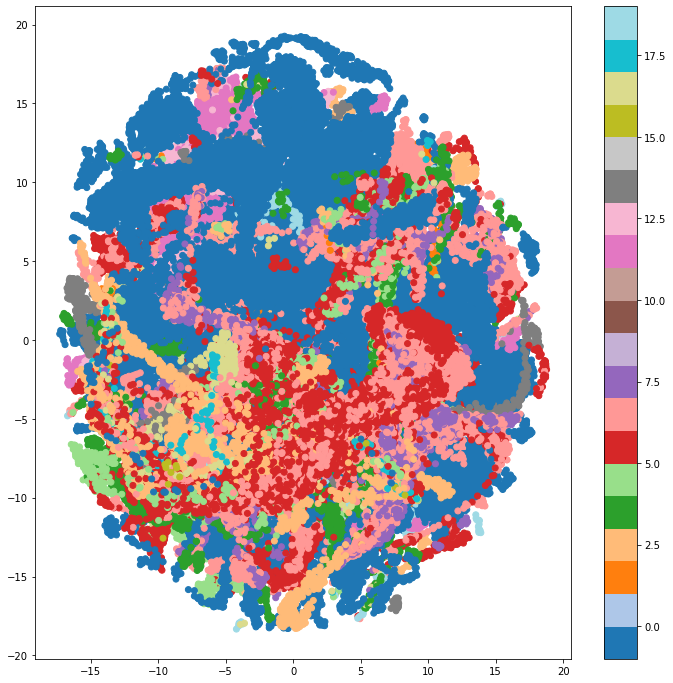

In [49]:
import matplotlib as mpl
cmap = mpl.cm.get_cmap('viridis', NUM_LITH)
plt.figure(figsize=(12,12))
plt.scatter(embedding[:,0], embedding[:,1], c=feature_df['LITHOLOGY_GEOLINK'], cmap='tab20')
plt.colorbar()